<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Fall2024/blob/main/Module_3/8_Clustering_EELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Tutorial notebook for the Fall 2024 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

- Instructor Sergei V. Kalinin
- EELS data by Kevin Roccapriore, Oak Ridge National Laboratory

Special point:
- ChatGPT will augment your power as a coder
- If and only if you know what you want to accomplish!

In [1]:
from copy import deepcopy as dc

import numpy as np
from sklearn import decomposition

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

Download EELS data. This is 12 EELS spectral data sets of indium-tin oxide cubes aquired by Kevin Roccapriore, measured at different resolutions and geometries. Pick the one you like!

In [2]:
%%capture
!wget https://www.dropbox.com/s/nicyvttpihzh1cd/Plasmonic_sets_7222021_fixed.npy
loadedfile = np.load("Plasmonic_sets_7222021_fixed.npy", allow_pickle=True).tolist()

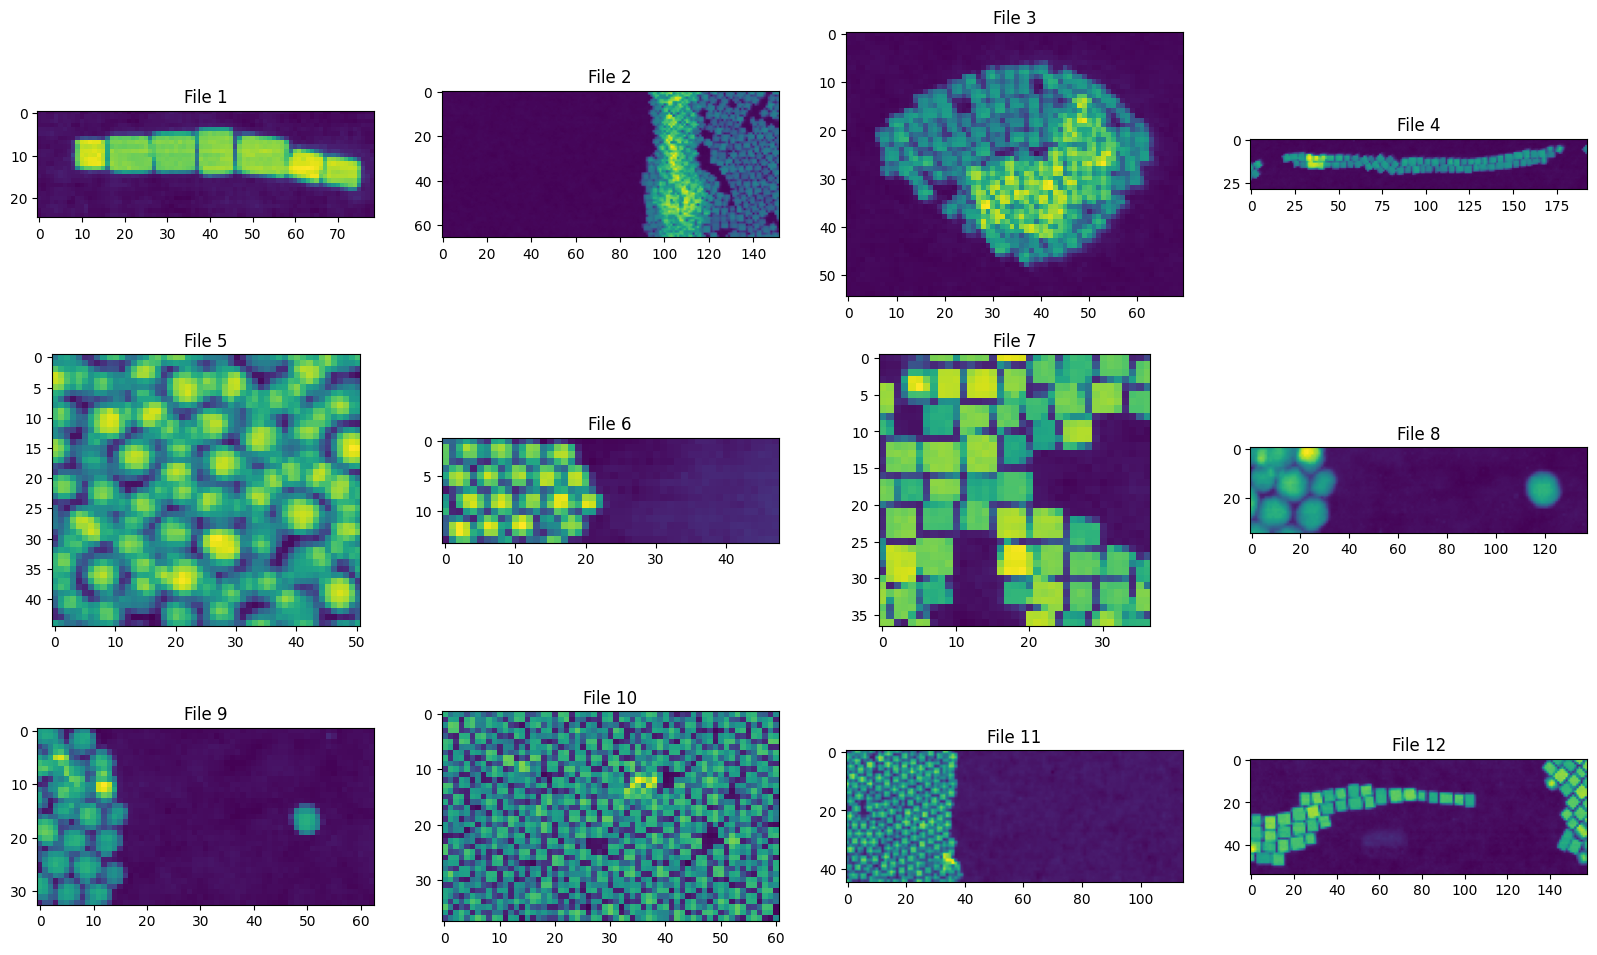

In [3]:
num_im = len(loadedfile)
rows = int(np.ceil(float(num_im)/4))
cols = int(np.ceil(float(num_im)/rows))

gs = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (5*cols, 3*(1+rows)))

for kk in range(num_im):
    ax = fig.add_subplot(gs[kk])
    fileset  = loadedfile['{}'.format(kk+1)]
    f1,f2,f3,f4 = fileset
    img, data, e_ax, img_scale = fileset[f1], fileset[f2], fileset[f3], fileset[f4]
    ax.imshow(img)
    ax.set_title("File {}".format(kk+1))

In [4]:
# Choose the file for analysis

k = 3
img = loadedfile['{}'.format(k)]['image']
specim = loadedfile['{}'.format(k)]['spectrum image']
e_ax = loadedfile['{}'.format(k)]['energy axis']
imscale = loadedfile['{}'.format(k)]['scale']

In [5]:
# Read grid spectoscopy data

hdata = specim
hdata = hdata.astype(np.float64)

Visual inspection of the :

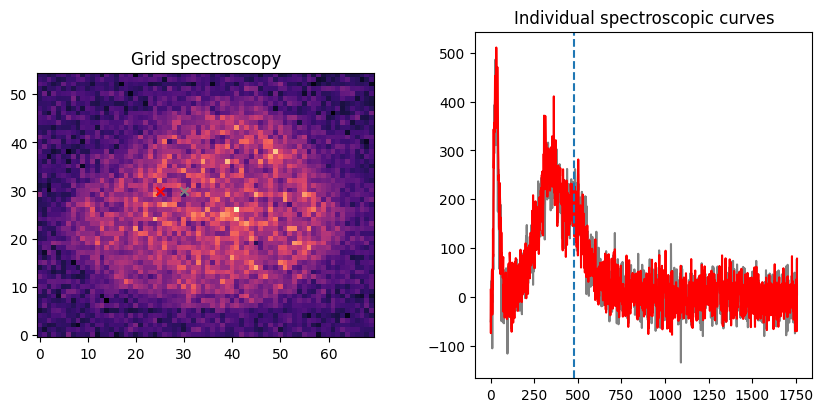

In [6]:
# Select a slice and points for extracting idividual spectoscopic curves
# For convenience, we look at the data in pixels (however, we store the real scale as e_ax)

s = 480 # slice
pos1 = [30, 30]
pos2 = [25, 30]

# Plot
_, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(hdata[..., s], cmap='magma', origin="lower")
ax[0].scatter(pos1[0], pos1[1], c='gray', marker='x')
ax[1].plot(hdata[pos1[1], pos1[0], :], c='gray')
ax[0].scatter(pos2[0], pos2[1], c='red', marker='x')
ax[1].plot(hdata[pos2[1], pos2[0], :], c='red')
ax[1].axvline(x=s, linestyle = '--')
ax[0].set_title('Grid spectroscopy')
ax[1].set_title('Individual spectroscopic curves')
plt.subplots_adjust(wspace=.3)

Important considerations for subsequent analysis.
 - For "real" analysis, make sure that before any subsequent analysis the data is properly curated. For EELS this is zero loss peak subtraction and log-log deconvolution. This will affect analysis very strongly (e.g. zerol-loss peak will dominate everything if not accounted for).
 - You can also consider downsampling the data (just average pool).
 - Finally, always keep track on whether you normalize data and how (all spectra 0 to 1, or all normalized to total maximum)
 - And keep track on whether average is subtracted.
 - Normalization and average subtraction will affect the analysis results. In our experience, there is no right way or wrong way for doing it - different preprocessing highlights dissimilar aspects of the physics of the system. However, it is important to keep track of these.  

# Clustering methods: K-means clustering, Gaussian mixture models

Finally, we can also perform clustering or Gaussian mixture modeling to better visualize what is occurring in these datasets. K-Means is a simple algorithm that attempts to assign labels to each spectrum, such that the within-cluster sum of squares is minimized, i.e. the variance in each cluster is minimial. This unsupervised ML algorithm is very powerful.

Similarly, if one has data that is expected to be from multiple gaussian distributions (or can be approximated as such), Gaussian mixture model can be used to assign each datapoint to one of these Gaussian distributions and learn the parameters of these distributions (means, covariances). This can also be very helpful to observe changes in behaviors. Let's try these on the above dataset.

In [7]:
X_vec = hdata.copy()
d1, d2, d3 = X_vec.shape
X_vec = X_vec.reshape(d1*d2, d3)
X_vec = (X_vec - np.min(X_vec)) / np.ptp(X_vec)

In [8]:
d1, d2, d3

(55, 70, 1758)

## K Means Clustering

Here we will do k-means clustering by using the scikit-learn package

In [9]:
## import library
from sklearn.cluster import KMeans

n_clusters = 7

km = KMeans(n_clusters) #choose number of clusters
km_results = km.fit(np.array(X_vec)) #we can intelligently fold the data and perform Kmeans

#Get the cluster centers and the labels
km_labels = km_results.labels_
km_centers = km_results.cluster_centers_

#Reshape the labels
km_labels = km_labels.reshape(d1, d2)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


<ipython-input-10-b3c5dd364178>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', km.n_clusters) #make a colormap, number of colors being the number of clusters


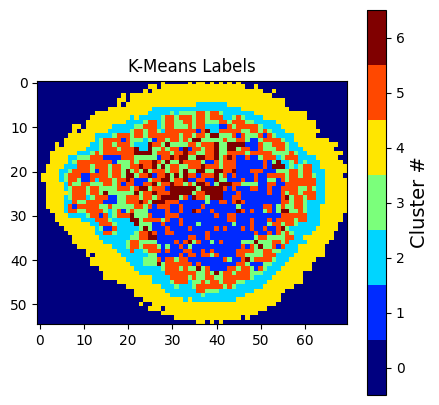

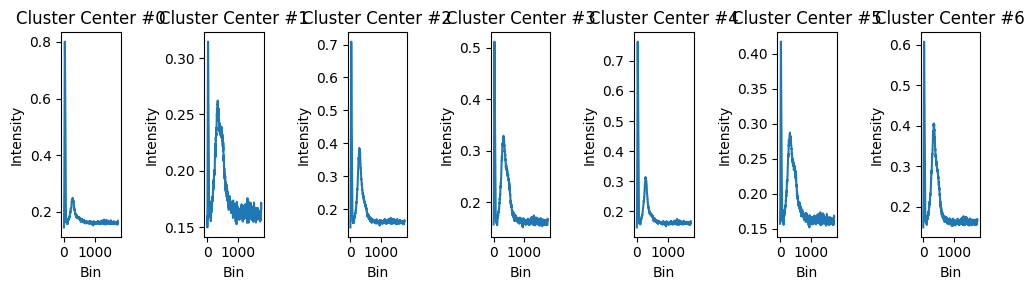

In [10]:
#Plot the results

#Plot the labels
cmap = plt.cm.get_cmap('jet', km.n_clusters) #make a colormap, number of colors being the number of clusters

#Plot the cluster labels
fig, axes = plt.subplots(figsize=(5,5))
im = axes.imshow(km_labels, cmap=cmap,vmin=np.min(km_labels) - 0.5,
                      vmax=np.max(km_labels) + 0.5)
axes.set_title('K-Means Labels')
cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_yticks(np.arange(np.min(km_labels), np.max(km_labels) + 1))
cbar.ax.set_ylabel("Cluster #", fontsize = 14)

#Plot the cluster centers
fig, axes = plt.subplots(nrows=1, ncols=km.n_clusters, figsize = (10,3))
for ind, ax in enumerate(axes.flat):
    ax.plot(km_centers[ind,:])
    ax.set_title('Cluster Center #' + str(ind))
    ax.set_ylabel("Intensity")
    ax.set_xlabel("Bin")
fig.tight_layout()

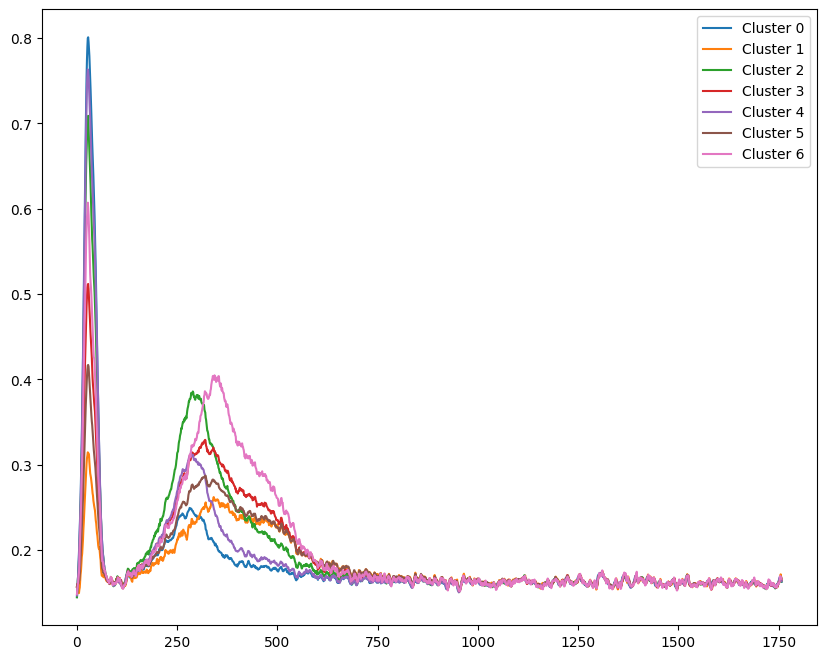

In [11]:
plt.figure(figsize=(10, 8))
labels = []

for ind in np.arange(km.n_clusters):
    plt.plot(km_centers[ind, :])
    labels.append(f"Cluster {ind}")

plt.legend(labels)  # Pass the list of labels to plt.legend()
plt.show()

With a little bit of help from ChatGPT, we can make a nice figure that combines graphs, labeled image, and legend (we can drop legend and just use colors).

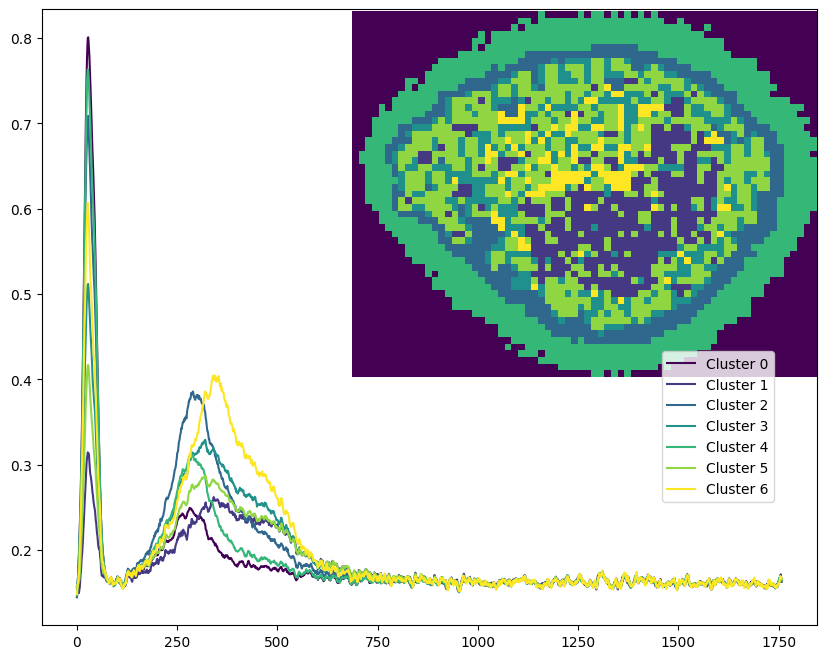

In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from sklearn.cluster import KMeans

# Set the color map to match the number of clusters
colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))

plt.figure(figsize=(10, 8))
labels = []

for ind, color in zip(np.arange(n_clusters), colors):
    plt.plot(km_centers[ind, :], color=color)
    labels.append(f"Cluster {ind}")

plt.legend(labels, loc=(0.8, 0.2))

# Create inset for image
ax = plt.gca()
axins = ax.inset_axes([0.4, 0.4, 0.6, 0.6])

# Use the same color map for the inset image
# Normalize the values to match the number of clusters
norm = mcolors.Normalize(vmin=km_labels.min(), vmax=km_labels.max())
im2_colored = plt.cm.viridis(norm(km_labels))
axins.imshow(im2_colored)
axins.axis('off')

plt.show()

## Gaussian mixture modeling

Now we will perform Gaussian mixture modeling

In [13]:
## import library
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=4,covariance_type="diag") #choose number of components

gmm_results = gmm.fit(np.array(X_vec)) #we can intelligently fold the data and perform GM
gmm_labels = gmm_results.fit_predict(X_vec)
gmm_means = gmm_results.means_


<ipython-input-14-71b10f334abf>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('jet', gmm.n_components) #make a colormap, number of colors being the number of clusters


Text(0, 0.5, 'GMM Label')

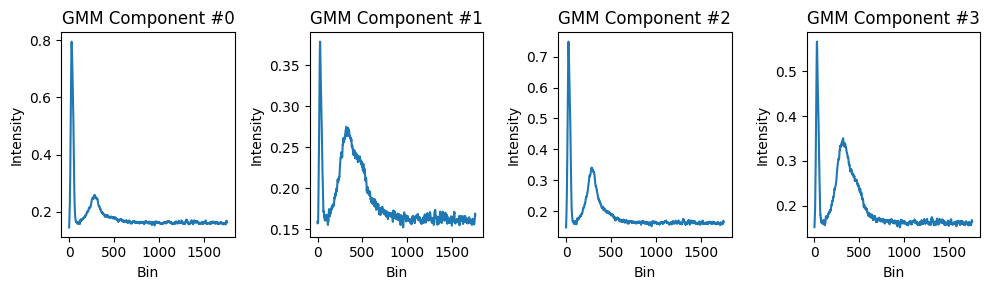

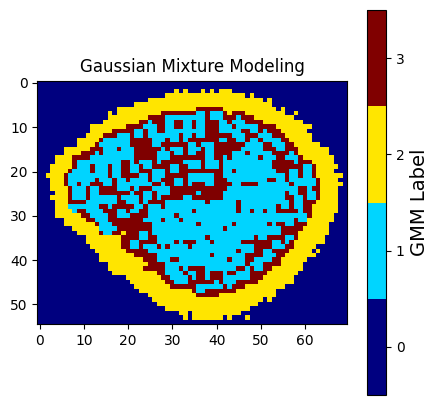

In [14]:
gmm_labels= gmm_labels.reshape(d1, d2)

#Plot the GMM means
fig, axes = plt.subplots(nrows=1, ncols=gmm.n_components, figsize = (10,3))
for ind, ax in enumerate(axes.flat):
    ax.plot(gmm_means[ind,:])
    ax.set_title('GMM Component #' + str(ind))
    ax.set_ylabel("Intensity")
    ax.set_xlabel("Bin")
fig.tight_layout()

#Plot the labels
cmap = plt.cm.get_cmap('jet', gmm.n_components) #make a colormap, number of colors being the number of clusters

#Plot the cluster labels
fig, axes = plt.subplots(figsize=(5,5))
im = axes.imshow(gmm_labels, cmap=cmap,vmin=np.min(gmm_labels) - 0.5,
                      vmax=np.max(gmm_labels) + 0.5)
axes.set_title('Gaussian Mixture Modeling')
cbar = fig.colorbar(im, ax=axes)
cbar.ax.set_yticks(np.arange(np.min(gmm_labels), np.max(gmm_labels) + 1))
cbar.ax.set_ylabel("GMM Label", fontsize = 14)

In [15]:
print('Weights of the GMM are ' + str(gmm.weights_))

Weights of the GMM are [0.3612609  0.26573012 0.19224559 0.18076338]


## Exercises

1. Play with number of components/clusters and see how the results differ. Think about how you might be able to determine the appropriate number of clusters/components.

2. What is the main difference between the EELS spectra based on the components?

3. It is often better to perform GMM on a much smaller feature space. Use PCA to reduce the dimensionality to 2, and then perform GMM. Then plot the density estimation from the model (see the scikit-learn documentation <a href="https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html">here</a>).
